<a href="https://www.kaggle.com/code/khethanrg/metal-surface-defect-detection?scriptVersionId=131547495" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import os
import itertools
from keras.utils import np_utils
from sklearn.preprocessing import Normalizer, scale
from sklearn.datasets import load_files
import tensorflow as tf
from tensorflow import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
import IPython
from IPython.display import display
from PIL import Image

%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [2]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])

In [3]:
# Loading the Dataset

In [4]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
val_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir='/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
print("Path Direcorty:      ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"))
print("Train Direcorty:     ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train"))
print("Test Direcorty:      ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty:",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid"))

Path Direcorty:       ['Thumbs.db', 'valid', 'test', 'train']
Train Direcorty:      ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Test Direcorty:       ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Validation Direcorty: ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']


In [5]:
# Distribution for 'Inclusion' surface defect
print("Training Inclusion data:  ",len(os.listdir(train_dir+'/'+'Inclusion')))
print("Testing Inclusion data:   ",len(os.listdir(test_dir+'/'+'Inclusion')))
print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data:   276
Testing Inclusion data:    12
Validation Inclusion data: 12


# Data Preperation & Augmentation

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale = 1. / 255, # rescaling
    rotation_range = 8, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    shear_range = 0.3, # shear angle in counter-clockwise direction in degrees  
    width_shift_range = 0.08, # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.08, # randomly shift images vertically (fraction of total height)
    vertical_flip = True, # randomly flip images
    horizontal_flip = True) # randomly flip images


test_datagen = ImageDataGenerator(rescale = 1. / 255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ): # Stop training the model at 98% traning accuracy
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

# <span style="color:#646464">Building 2D Convolutional Neural Network</span> 🧠

In [8]:
# Building a 2D ConvNet
# CNN is derived from the convolutional operator (dot product of 2 functions to produce a 3rd function)

model = Sequential() # Sequential Keras API which is a linear stack of layers

model.add(Conv2D(filters = 32, # The number of filters (Kernels) used with this layer
                 
                 kernel_size = (5, 5), # The dimensions of the feature map
                 
                 activation = "relu", # Activation function - Rectified Linear Unit (ReLU)
                 
                 strides = 1, # How much the window (feature map) shifts by in each of the dimensions
                 
                 padding = "same", # When stride = 1, output spatial shape is the same as input spatial shape
                 
                 # There are two conventions for shapes of images tensors: the channels-last convention 
                 # (used by TensorFlow) and the channels-first convention (used by Theano)." 
                 # Deep Learning with Python - François Chollet
                 data_format = "channels_last",
                 
                 input_shape = (200, 200, 3))) # Input image dimensions

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", 
                 strides = 1, padding = "same", data_format = "channels_last"))

# Max Pooling reduces the spatial dimensions of the feature maps before the fully connected layers
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", 
                 strides = 1, padding = "same", data_format = "channels_last"))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", 
                 strides = 1, padding = "same", data_format = "channels_last"))

model.add(MaxPooling2D(pool_size = (2, 2)))
    
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", 
                 strides = 1, padding = "same", data_format = "channels_last"))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", 
                 strides = 1, padding = "same", data_format = "channels_last"))

model.add(MaxPooling2D(pool_size = (2, 2)))

# To help avoid overfitting we can add Dropout. 
# This randomly drops some percentage of neurons, and thus the weights become re-aligned
model.add(Dropout(0.1))

# Finally, we can add a flatten layer to map the input to a 1D vector
# We then add fully connected (dense) layers after some convolutional/pooling layers.

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(6, activation = "softmax")) # activation function for Multi-Class Classification

In [9]:
optimizer = Adam(lr = 0.00002)
# Adam will increase the learning rate when the coefficients are moving in roughly the same direction

In [10]:
# Compiling the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 128)       7

# <span style="color:#646464">Fitting the Model</span> 🛠

In [12]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 16,
        epochs = 50,
        validation_data = validation_generator,
        callbacks = [callbacks],
        verbose = 1, shuffle = True)

Epoch 1/50
166/166 [==============================] - 44s 178ms/step - loss: 1.7604 - accuracy: 0.1981 - val_loss: 1.6758 - val_accuracy: 0.3333
Epoch 2/50
166/166 [==============================] - 19s 113ms/step - loss: 1.4675 - accuracy: 0.3551 - val_loss: 1.3222 - val_accuracy: 0.4444
Epoch 3/50
166/166 [==============================] - 19s 117ms/step - loss: 1.2438 - accuracy: 0.4777 - val_loss: 1.0593 - val_accuracy: 0.5833
Epoch 4/50
166/166 [==============================] - 19s 114ms/step - loss: 1.0874 - accuracy: 0.5537 - val_loss: 0.7605 - val_accuracy: 0.7639
Epoch 5/50
166/166 [==============================] - 20s 119ms/step - loss: 0.9764 - accuracy: 0.6135 - val_loss: 0.8193 - val_accuracy: 0.6806
Epoch 6/50
166/166 [==============================] - 19s 117ms/step - loss: 0.8558 - accuracy: 0.6691 - val_loss: 0.5488 - val_accuracy: 0.8611
Epoch 7/50
166/166 [==============================] - 19s 113ms/step - loss: 0.7173 - accuracy: 0.7319 - val_loss: 0.8756 - val_ac

# Training and Validation Curves

<Figure size 1200x800 with 0 Axes>

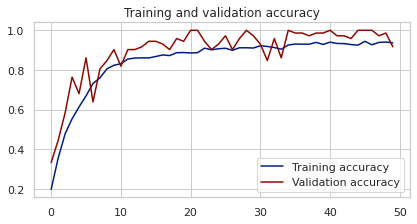

<Figure size 1200x800 with 0 Axes>

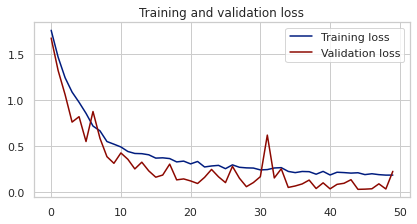

In [13]:
plt.figure(dpi = 200)
plt.figure(figsize = (6, 3))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label = "Training accuracy")
plt.plot(epochs, val_accuracy, 'r', label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

plt.figure(dpi = 200)
plt.figure(figsize = (6, 3))
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


# <span style="color:#646464">Visualize Predictions</span> 📊

In [14]:
# First, we are going to load the file names and their respective target labels into numpy array! 

test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [15]:
no_of_classes = len(np.unique(y_test))
y_test = np_utils.to_categorical(y_test, no_of_classes)

In [16]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [17]:
x_test = x_test.astype('float32')/255

In [18]:
# Final results
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)


1/1 [==============================] - 2s 2s/step - loss: 0.3927 - accuracy: 0.8194
test loss, test acc: [0.392671138048172, 0.8194444179534912]


In [19]:
model.save('my_model.h5')

In [20]:
# keras.backend.clear_session()

In [21]:
!pip install streamlit -q

In [22]:
!pip install --upgrade opencv-python -q

In [25]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import io

new_model = tf.keras.models.load_model("my_model.h5")

# Define class names
class_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted Surface', 'Rolled-in Scale', 'Scratches']

# Function to convert image to grayscale if it is RGB
def convert_to_grayscale(img):
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

# Function to detect defects
def detect_defects(img):
    st.text(img.shape)
    #img = convert_to_grayscale(img)
    new_img = img.astype('float32')/255
    if new_img is not None:
        # Reshape input to match model's input shape
        new_img = np.reshape(new_img, (1, new_img.shape[0], new_img.shape[1], -1))
        st.text(new_img.shape)
        # Make predictions
        prediction = new_model.predict(new_img)
        # Get the index of the class with the highest probability
        predicted_class_index = np.argmax(prediction)
        # Get the name of the predicted class
        predicted_class_name = class_names[predicted_class_index]
        return predicted_class_name
    else:
        return 'no image detected'

# Function to convert uploaded image to array and detect defects
def convert_image_to_array(image_bytes):
    # If image_bytes is already in bytes format, skip the bytearray() step
    if isinstance(image_bytes, bytes):
        img_array = np.asarray(bytearray(image_bytes), dtype=np.uint8)
    else:
        with open(image_bytes, 'rb') as f:
            img_array = np.asarray(bytearray(f.read()), dtype=np.uint8)
    
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (200, 200))
    return img

# Streamlit app
def app():
    st.title("Defect Detection App")
    # File uploader
    uploaded_file = st.file_uploader("Choose an image...", type=["bmp","jpg", "jpeg", "png"])
    if uploaded_file is not None:
        # Show uploaded image
        img_bytes = uploaded_file.read()
        img_format = uploaded_file.type.split('/')[1]
        img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
        st.image(img, caption="Uploaded Image", use_column_width=True)
        # Detect defects
        if st.button("Detect Defects"):
            output = detect_defects(convert_image_to_array(img_bytes))
            st.write(output)
            st.success("Defects detected!")

app()

Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://35.224.160.49:8501

####......] - refresh-package-json:localtunnel: timing action:finalizenpx: installed 22 in 4.673s
your url is: https://rare-carrots-rhyme-35-224-160-49.loca.lt
